# JetNet Demo

<img src="https://raw.githubusercontent.com/rkansal47/JetNet/main/docs/_static/images/jetnetlogo.png" alt="logo" width="500"/>

<h3>Raghav Kansal<br>UC San Diego</h3>

<h3><span style="color:gray"><a href="https://indico.cern.ch/e/PyHEP2022">PyHEP 2022 Workshop</a><br>Online, 12-16 September 2022</span></h3>


<h4>JetNet: For developing and reproducing ML + HEP projects.</h4>


Repo: [github.com/jet-net/JetNet](https://github.com/jet-net/JetNet)

Docs: [jetnet.readthedocs.io](https://jetnet.readthedocs.io/en/latest/)

Paper: [2106.11535](https://arxiv.org/abs/2106.11535)

## Introduction

### Problems:
 - How do I **get started** with machine learning in high energy physics?
 - How do I **evaluate** my results?
 - How do we **reproduce** and **compare** results?
 
### Solution:

JetNet: Python package with easy-to-access datasets, standardised evaluation metrics, and more utilities for improving accessibility and reproducibility in ML + HEP.

#### Note: Still under development, with currently a limited number of datasets and metrics. Feedback and contributions welcome!

## Today

 - Loading and looking at the JetNet dataset
 - Preparing the dataset for training a model

## Data loading

We'll use the `jetnet.datasets.JetNet.getData` function to download and directly access the dataset.

First, we can check which particle and jet features are available in this dataset:

In [14]:
from jetnet.datasets import JetNet

print(f"Particle features: {JetNet.all_particle_features}")
print(f"Jet features: {JetNet.all_jet_features}")

Particle features: ['etarel', 'phirel', 'ptrel', 'mask']
Jet features: ['type', 'pt', 'eta', 'mass', 'num_particles']


Next, let's load the data:

In [15]:
data_args = {
    "jet_type": ["g", "t", "w"],  # gluon, top quark, and W boson jets
    "data_dir": "datasets/jetnet",
    # only selecting the kinematic features
    "particle_features": ["etarel", "phirel", "ptrel"],
    "num_particles": 30,
    "jet_features": ["type", "pt", "eta", "mass"],
}

particle_data, jet_data = JetNet.getData(**data_args)

Let's look at some of the data:

In [16]:
print(
    f"Particle features of the 10 highest pT particles in the first jet\n{data_args['particle_features']}\n{particle_data[0, :10]}"
)
print(f"\nJet features of first jet\n{data_args['jet_features']}\n{jet_data[0]}")

Particle features of the 10 highest pT particles in the first jet
['etarel', 'phirel', 'ptrel']
[[-0.04361616 -0.00706771  0.29305124]
 [-0.04611618 -0.00956919  0.06966697]
 [-0.04163383 -0.00890653  0.05733829]
 [ 0.13638385 -0.00706771  0.04643776]
 [-0.04111616 -0.0045667   0.04290354]
 [-0.04223531  0.00299934  0.03603047]
 [ 0.10638386  0.01294228  0.03550573]
 [-0.0461162  -0.01457169  0.03525265]
 [-0.04251299 -0.00919492  0.02895915]
 [-0.04227024 -0.01043073  0.02826967]]

Jet features of first jet
['type', 'pt', 'eta', 'mass']
[3.00000000e+00 1.13473572e+03 6.48616195e-01 8.08584366e+01]


We can also visualise these jets as images:

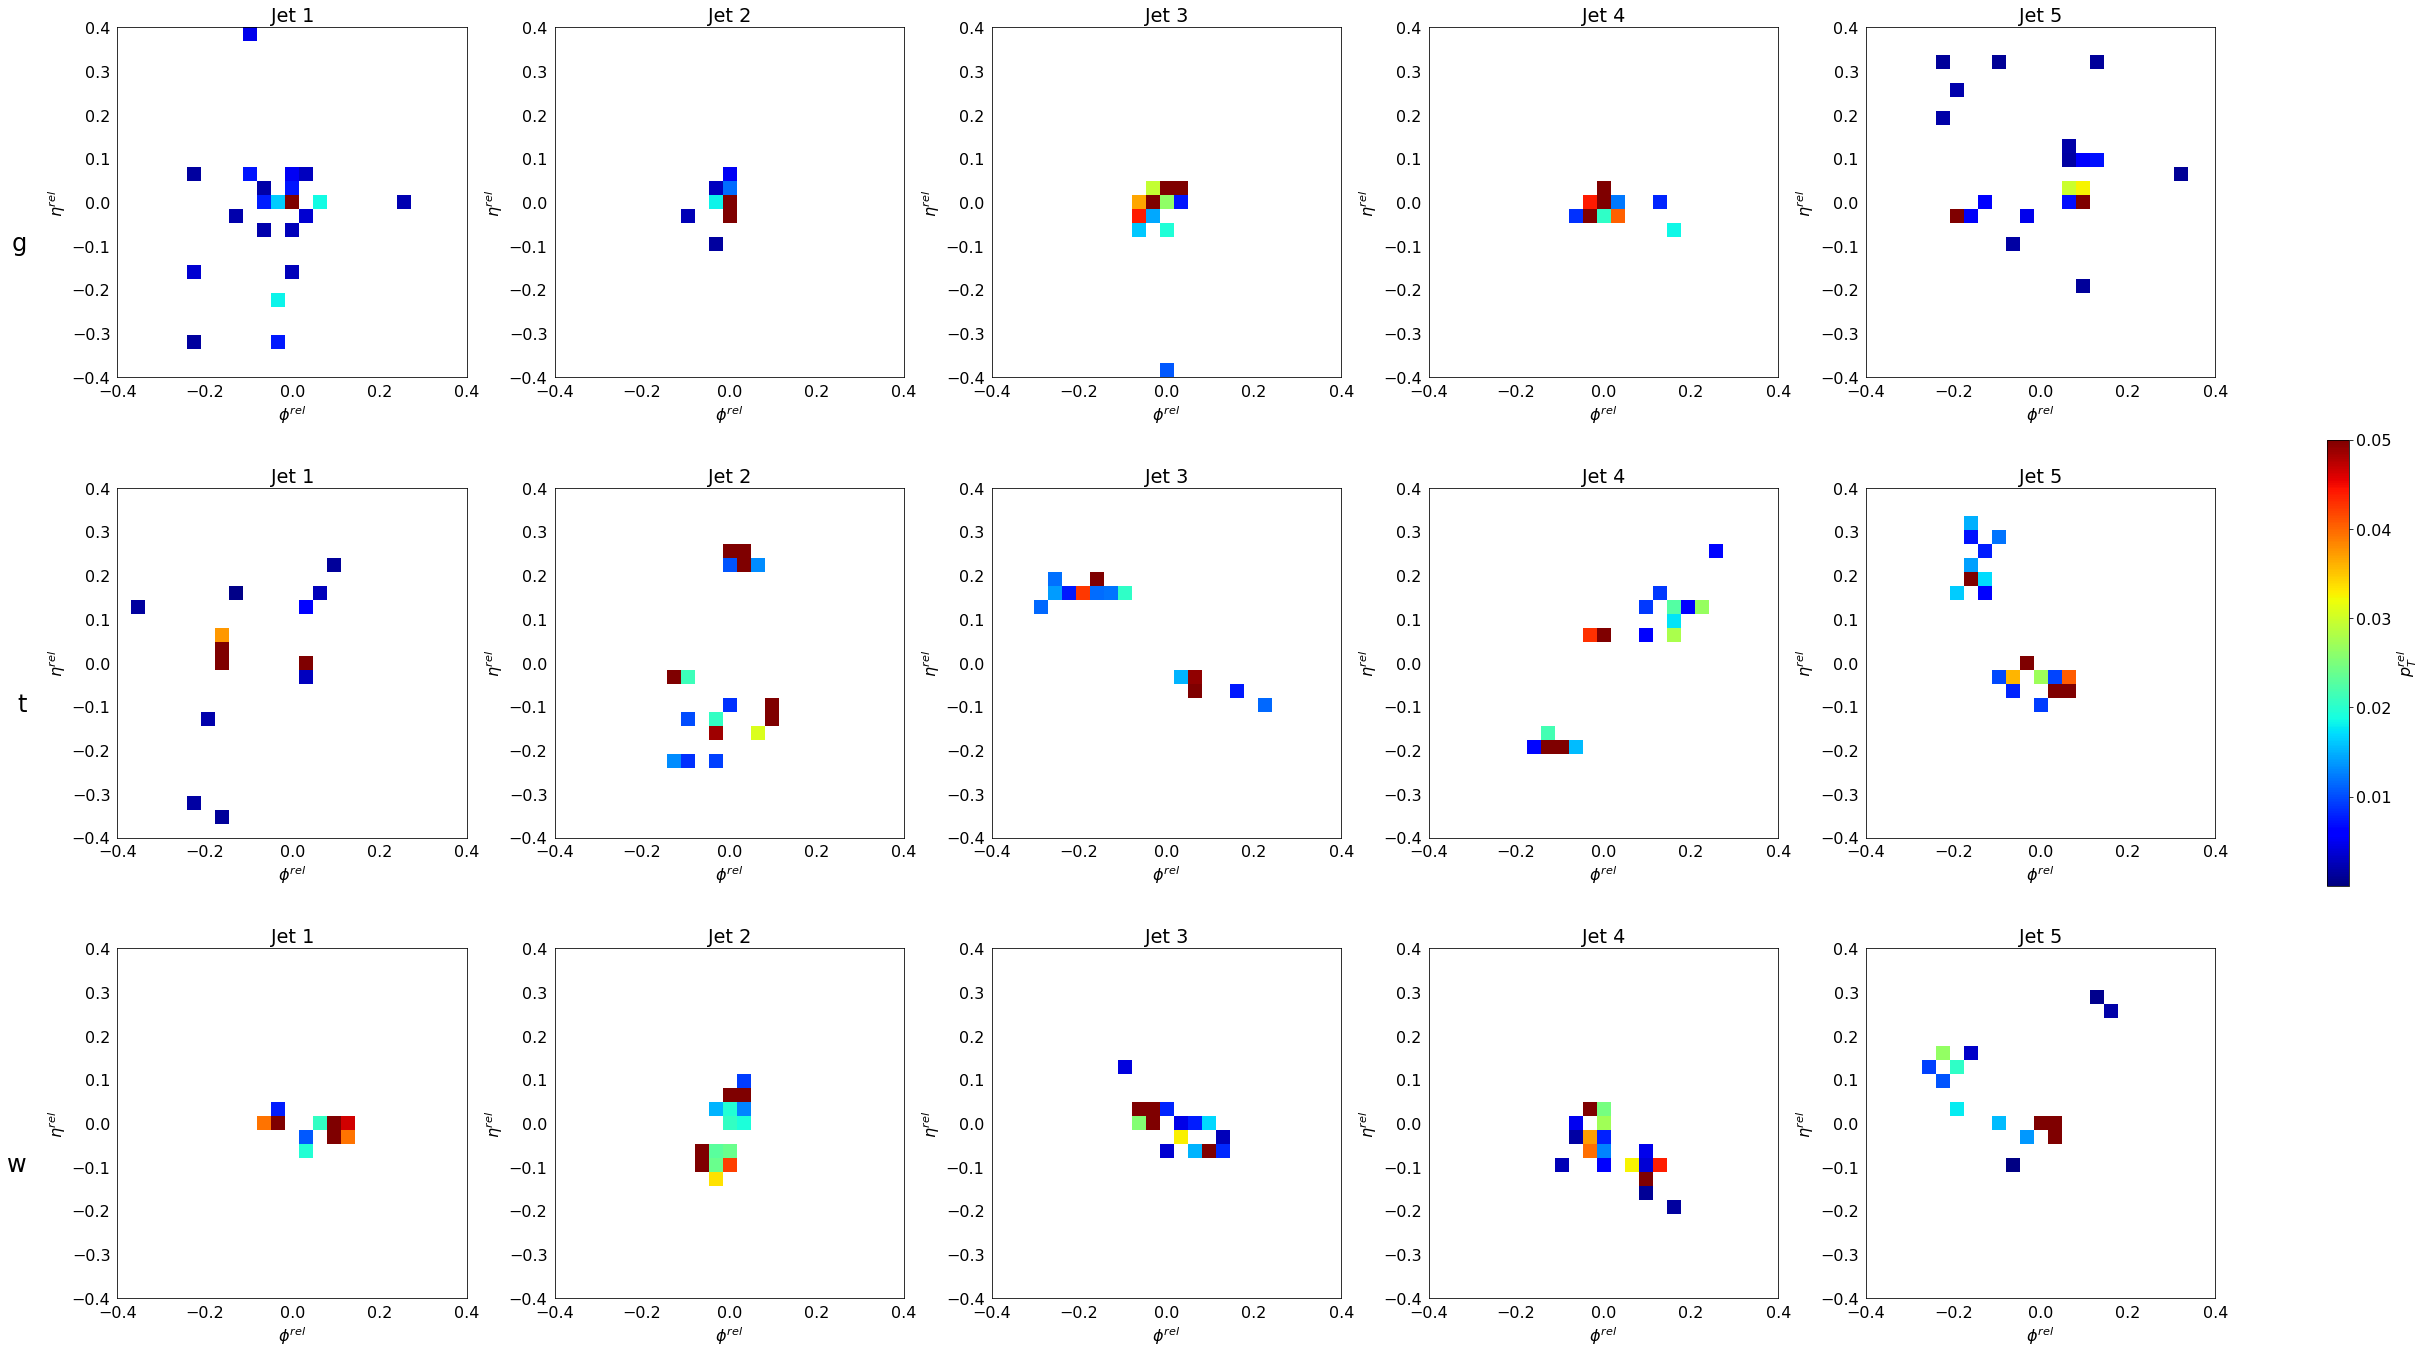

In [17]:
from jetnet.utils import to_image
import matplotlib.pyplot as plt

num_images = 5
num_types = len(data_args["jet_type"])
im_size = 25  # number of pixels in height and width
maxR = 0.4  # max radius in (eta, phi) away from the jet axis

cm = plt.cm.jet.copy()
cm.set_under(color="white")
plt.rcParams.update({"font.size": 16})

fig, axes = plt.subplots(
    nrows=num_types,
    ncols=num_images,
    figsize=(40, 8 * num_types),
    gridspec_kw={"wspace": 0.25},
)

# get the index of each jet type using the JetNet.jet_types array
type_indices = {jet_type: JetNet.jet_types.index(jet_type) for jet_type in data_args["jet_type"]}

for j in range(num_types):
    jet_type = data_args["jet_type"][j]
    type_selector = jet_data[:, 0] == type_indices[jet_type]  # select jets based on jet_type feat

    axes[j][0].annotate(
        jet_type,
        xy=(0, -1),
        xytext=(-axes[j][0].yaxis.labelpad - 15, 0),
        xycoords=axes[j][0].yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center",
        fontsize=24,
    )

    for i in range(num_images):
        im = axes[j][i].imshow(
            to_image(particle_data[type_selector][i], im_size, maxR=maxR),
            cmap=cm,
            interpolation="nearest",
            vmin=1e-8,
            extent=[-maxR, maxR, -maxR, maxR],
            vmax=0.05,
        )
        axes[j][i].tick_params(which="both", bottom=False, top=False, left=False, right=False)
        axes[j][i].set_xlabel("$\phi^{rel}$")
        axes[j][i].set_ylabel("$\eta^{rel}$")
        axes[j][i].set_title(f"Jet {i + 1}")

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.01)
cbar.set_label("$p_T^{rel}$")

And calculate and plot their overall features:

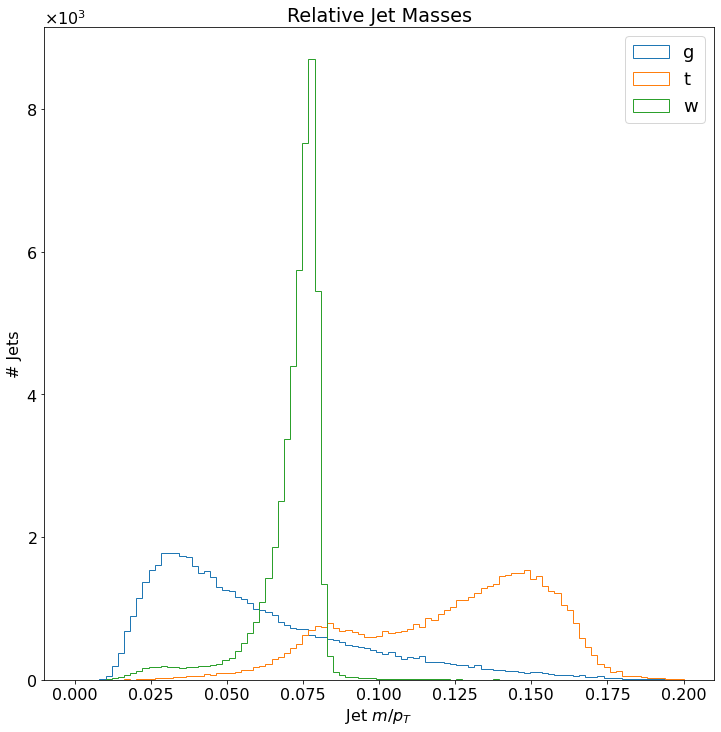

In [18]:
from jetnet.utils import jet_features
import numpy as np

fig = plt.figure(figsize=(12, 12))
plt.ticklabel_format(axis="y", scilimits=(0, 0), useMathText=True)

for j in range(num_types):
    jet_type = data_args["jet_type"][j]
    type_selector = jet_data[:, 0] == type_indices[jet_type]  # select jets based on jet_type feat

    jet_masses = jet_features(particle_data[type_selector][:50000])["mass"]
    _ = plt.hist(jet_masses, bins=np.linspace(0, 0.2, 100), histtype="step", label=jet_type)

plt.xlabel("Jet $m/p_{T}$")
plt.ylabel("# Jets")
plt.legend(loc=1, prop={"size": 18})
plt.title("Relative Jet Masses")
plt.show()

## Dataset preparation

To prepare the dataset for machine learning applications, we can use the `jetnet.datasets.JetNet` class itself, which inherits the `pytorch.data.utils.Dataset` class.

We'll also use the class to **normalise** the features to have zero means and unit standard deviations, and **transform** the jet type feature to be one-hot-encoded.

In [19]:
from jetnet.datasets import JetNet
from jetnet.datasets.normalisations import FeaturewiseLinear

import numpy as np
from sklearn.preprocessing import OneHotEncoder


# function to one hot encode the jet type and leave the rest of the features as is
def OneHotEncodeType(x: np.ndarray):
    enc = OneHotEncoder(categories=[[0, 1]])
    type_encoded = enc.fit_transform(x[..., 0].reshape(-1, 1)).toarray()
    other_features = x[..., 1:].reshape(-1, 3)
    return np.concatenate((type_encoded, other_features), axis=-1).reshape(*x.shape[:-1], -1)


data_args = {
    "jet_type": ["g", "t"],  # gluon and top quark jets
    "data_dir": "datasets/jetnet",
    # these are the default particle features, written here to be explicit
    "particle_features": ["etarel", "phirel", "ptrel", "mask"],
    "num_particles": 10,  # we retain only the 10 highest pT particles for this demo
    "jet_features": ["type", "pt", "eta", "mass"],
    # we don't want to normalise the 'mask' feature so we set that to False
    "particle_normalisation": FeaturewiseLinear(
        normal=True, normalise_features=[True, True, True, False]
    ),
    # pass our function as a transform to be applied to the jet features
    "jet_transform": OneHotEncodeType,
}

jets_train = JetNet(**data_args, split="train")
jets_valid = JetNet(**data_args, split="valid")

We can look at one of our datasets to confirm everything is as we expect:

In [20]:
jets_train

Dataset JetNet
    Number of datapoints: 248637
    Data location: datasets/jetnet
    Including ['g', 't'] jets
    Split into train data out of ['train', 'valid', 'test', 'all'] possible splits, with splitting fractions [0.7, 0.15, 0.15]
    Particle features: ['etarel', 'phirel', 'ptrel', 'mask'], max 10 particles per jet
    Jet features: ['type', 'pt', 'eta', 'mass']
    Particle normalisation: Normalising features to zero mean and unit standard deviation, normalising features: [True, True, True, False]
    Jet transform: <function OneHotEncodeType at 0x15f8a6560>

And also directly at the data itself - note that the features have been **normalised** and the jet type has been **one-hot-encoded**):

In [21]:
particle_features, jet_features = jets_train[0]
print(f"Particle features ({data_args['particle_features']}):\n\t{particle_features}")
print(f"\nJet features ({data_args['jet_features']}):\n\t{jet_features}")

Particle features (['etarel', 'phirel', 'ptrel', 'mask']):
	tensor([[-1.5952e-03, -9.4181e-04,  6.7592e-01,  1.0000e+00],
        [ 1.3819e-03,  6.9232e-03,  9.6110e-02,  1.0000e+00],
        [ 5.9048e-03, -3.4432e-03,  9.1700e-02,  1.0000e+00],
        [ 1.4783e-02, -1.0506e-02,  2.8433e-02,  1.0000e+00],
        [ 1.3316e-03, -8.1813e-03,  2.6264e-02,  1.0000e+00],
        [ 9.0482e-04,  1.1564e-02,  1.6956e-02,  1.0000e+00],
        [-1.4095e-02,  1.1564e-02,  1.3759e-02,  1.0000e+00],
        [ 2.5905e-02, -3.4432e-03,  1.1798e-02,  1.0000e+00],
        [-4.0952e-03,  6.5619e-03,  9.9370e-03,  1.0000e+00],
        [-9.0952e-03,  3.1575e-02,  8.2691e-03,  1.0000e+00]])

Jet features (['type', 'pt', 'eta', 'mass']):
	tensor([ 1.0000e+00,  0.0000e+00,  1.2301e+03, -1.7340e-01,  2.2097e+01])


<h4>We can now feed this into a PyTorch DataLoader and start training!</h4>

Next things you can try are:
 - Repeat this with the Top Quark Tagging (`jetnet.datasets.TopTagging`) and Quark Gluon datasets (`jetnet.datasets.QuarkGluon`)
 - Training an ML model (tutorial coming soon...)
 - Evaluating generative models (`jetnet.evaluation`)